## Standardize, clean and wrangle Water Quality Portal data in Cape Cod into more analytic-ready formats using the harmonize_wq package

US EPA’s Water Quality Portal (WQP) aggregates water quality, biological, and physical data provided by many organizations and has become an essential resource with tools to query and retrieval data using python or R. Given the variety of data and variety of data originators, using the data in analysis often requires data cleaning to ensure it meets the required quality standards and data wrangling to get it in a more analytic-ready format. Recognizing the definition of analysis-ready varies depending on the analysis, the harmonixe_wq package is intended to be a flexible water quality specific framework to help:
- Identify differences in data units (including speciation and basis)
- Identify differences in sampling or analytic methods
- Resolve data errors using transparent assumptions
- Reduce data to the columns that are most commonly needed
- Transform data from long to wide format

Domain experts must decide what data meets their quality standards for data comparability and any thresholds for acceptance or rejection.

The first part of this notebook walks through a typical harmonization process on data retrieved from Cape Cod, MA. The second part of the notebook takes a deeper dive into exactly what is done to each water quality characteristic result and some ways to leverage additional functions in the package for special use cases.

### Simple workflow

#### import the required libraries. Check requirements.txt for additional dependencies to install.

In [1]:
# Use pip to install the package from github
#!pip install git+git://github.com/USEPA/harmonize-wq.git
#!pip install git+https://github.com/USEPA/harmonize-wq.git#egg=harmonize-wq

In [2]:
from harmonize_wq import harmonize
from harmonize_wq import convert
from harmonize_wq import wrangle
from harmonize_wq import clean
from harmonize_wq import location
from harmonize_wq import visualize
import dataretrieval.wqp as wqp

#### Create dataretrieval query using a polygon for Area Of Interest

A url to a geojson is used to define the area to retrieve results, but this can come from a variety of sources, including a local shapefile.

<AxesSubplot:>

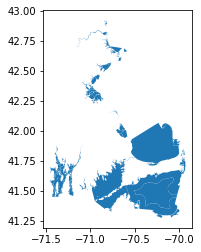

In [3]:
# Read geometry for Area of Interest from geojson file url
aoi_url = 'https://github.com/jbousquin/test_notebook/raw/main/temperature_data/NewEngland.geojson'
#aoi_url = r'<your filepath>\NewEngland.shp'  # Local shapefile alternative
aoi_gdf = wrangle.as_gdf(aoi_url)  # Read it to GeoDataFrame
aoi_gdf = aoi_gdf.to_crs(epsg=4326)  # Re-project aoi

# Map aoi
aoi_gdf.plot() # Requires descartes

The Area Of Interest is made up of many small polygons. The query will be built from the total extent of these polygons, but alternatively could be restricted to the bounding box for just one such polygon.

In [4]:
bBox = wrangle.get_bounding_box(aoi_gdf)  # Bounding box string for total extent
#bBox = wrangle.get_bounding_box(aoi_gdf, idx=0)  # Bounding box string for specific polygon by index

In [5]:
# Build query with characteristicNames and the AOI extent
query = {'characteristicName': ['Phosphorus',
                                'Temperature, water',
                                'Depth, Secchi disk depth',
                                'Dissolved oxygen (DO)',
                                'Salinity',
                                'pH',
                                'Nitrogen',
                                'Conductivity',
                                'Organic carbon',
                                'Chlorophyll a',
                                'Turbidity',
                                'Sediment',
                                'Fecal Coliform',
                                'Escherichia coli']}
query['bBox'] = bBox

#### Retrieve data

Stations and results meeting the query criteria are retrieved seperately. site_md and md_narrow are not used here but contain metadata to document and help reproduce the query/results in the future.

In [6]:
# Query for stations
stations, site_md = wqp.what_sites(**query)

In [7]:
# Query for results
query['dataProfile'] = 'narrowResult'
res_narrow, md_narrow = wqp.get_results(**query)

D:\Python\env\arcgispro-py3-spy-harmonize-wq\lib\site-packages\ipykernel_launcher.py:3: DtypeWarning: Columns (10,13,15,17,19,20,21,22,23,28,31,32,33,34,36,38,60,63,64,65,69,70,71,72) have mixed types.Specify dtype option on import or set low_memory=False.
  This is separate from the ipykernel package so we can avoid doing imports until


In [8]:
# Look at initial results (input)
df = res_narrow
df

,OrganizationIdentifier,OrganizationFormalName,ActivityIdentifier,ActivityStartDate,ActivityStartTime/Time,ActivityStartTime/TimeZoneCode,MonitoringLocationIdentifier,ResultIdentifier,DataLoggerLine,ResultDetectionConditionText,...,AnalysisEndTime/TimeZoneCode,ResultLaboratoryCommentCode,ResultLaboratoryCommentText,ResultDetectionQuantitationLimitUrl,LaboratoryAccreditationIndicator,LaboratoryAccreditationAuthorityName,TaxonomistAccreditationIndicator,TaxonomistAccreditationAuthorityName,LabSamplePreparationUrl,ProviderName
0,CRWA,Charles River Watershed Association (Massachus...,CRWA-CYN20130809ROBTemp01,2013-08-09,11:14:33,EST,CRWA-ROB,STORET-591631481,1.308091e+11,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STORET
1,11NPSWRD_WQX,National Park Service Water Resources Division,11NPSWRD_WQX-CACO_HX23_1_7/15/2013_NFW_0.957,2013-07-15,12:17:00,EDT,11NPSWRD_WQX-CACO_HX23_1,STORET-920925644,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STORET
2,MASSDEP,Massachusetts Department of Environmental Prot...,MASSDEP-LB-5142,2013-07-30,14:20:00,EDT,MASSDEP-W2173,STORET-762955917,NaN,NaN,...,NaN,NaN,NaN,https://www.waterqualitydata.us/data/providers...,NaN,NaN,NaN,NaN,NaN,STORET
3,IRWA,Ipswich River Watershed Association (Volunteer),IRWA-HB:20130630120000:FM,2013-06-30,12:00:00,EDT,IRWA-HB,STORET-853064665,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STORET
4,CRWA,Charles River Watershed Association (Massachus...,CRWA-VMM20131217609SEC02,2013-12-17,07:40:00,EST,CRWA-609S,STORET-872379847,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STORET
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295766,USGS-MA,USGS Massachusetts Water Science Center,nwisma.01.02201090,2022-05-05,12:15:00,EDT,USGS-01096548,NWIS-123268772,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
295767,USGS-MA,USGS Massachusetts Water Science Center,nwisma.01.02201090,2022-05-05,12:15:00,EDT,USGS-01096548,NWIS-123268782,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
295768,USGS-MA,USGS Massachusetts Water Science Center,nwisma.01.02201090,2022-05-05,12:15:00,EDT,USGS-01096548,NWIS-123268789,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
295769,USGS-MA,USGS Massachusetts Water Science Center,nwisma.01.02201090,2022-05-05,12:15:00,EDT,USGS-01096548,NWIS-123268791,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS


#### Harmonize data using defaults

In [9]:
# Harmonize it and look at how it changed (output)
# Note: although we ignore unit dimensionality errors, it will warn when they are encountered and there are a lot of them
df_harmonized = harmonize.harmonize_all(df, errors='ignore')
df_harmonized

D:\Python\env\arcgispro-py3-spy-harmonize-wq\lib\site-packages\pandas\core\dtypes\cast.py:1990: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values
D:\code\harmonize-wq\harmonize_wq\harmonize.py:154: UserWarning: WARNING: 'None' UNDEFINED UNIT for Secchi
  warn("WARNING: " + problem)
D:\code\harmonize-wq\harmonize_wq\harmonize.py:154: UserWarning: WARNING: 'cm3/g' UNDEFINED UNIT for Nitrogen
  warn("WARNING: " + problem)
D:\code\harmonize-wq\harmonize_wq\harmonize.py:154: UserWarning: WARNING: 'percent' UNDEFINED UNIT for Nitrogen
  warn("WARNING: " + problem)
D:\code\harmonize-wq\harmonize_wq\harmonize.py:154: UserWarning: WARNING: 'ppm' UNDEFINED UNIT for Nitrogen
  warn("WARNING: " + problem)
D:\Python\env\arcgispro-py3-spy-harmonize-wq\lib\site-packages\numpy\core\_asarray.py:102: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return array(a, dtype, copy=False, order=order)
D:\code\har

,OrganizationIdentifier,OrganizationFormalName,ActivityIdentifier,ActivityStartDate,ActivityStartTime/Time,ActivityStartTime/TimeZoneCode,MonitoringLocationIdentifier,ResultIdentifier,DataLoggerLine,ResultDetectionConditionText,...,TDP_Phosphorus,Other_Phosphorus,Unfiltered_Phosphorus,Bed_Sediment_Phosphorus,Temperature,pH,Salinity,Carbon,Fecal_Coliform,Chlorophyll
0,CRWA,Charles River Watershed Association (Massachus...,CRWA-CYN20130809ROBTemp01,2013-08-09,11:14:33,EST,CRWA-ROB,STORET-591631481,1.308091e+11,NaN,...,NaN,NaN,NaN,NaN,23.01 degree_Celsius,NaN,NaN,NaN,NaN,NaN
1,11NPSWRD_WQX,National Park Service Water Resources Division,11NPSWRD_WQX-CACO_HX23_1_7/15/2013_NFW_0.957,2013-07-15,12:17:00,EDT,11NPSWRD_WQX-CACO_HX23_1,STORET-920925644,NaN,NaN,...,NaN,NaN,NaN,NaN,26.1 degree_Celsius,NaN,NaN,NaN,NaN,NaN
2,MASSDEP,Massachusetts Department of Environmental Prot...,MASSDEP-LB-5142,2013-07-30,14:20:00,EDT,MASSDEP-W2173,STORET-762955917,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.004000000000000001 milligram / liter
3,IRWA,Ipswich River Watershed Association (Volunteer),IRWA-HB:20130630120000:FM,2013-06-30,12:00:00,EDT,IRWA-HB,STORET-853064665,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,CRWA,Charles River Watershed Association (Massachus...,CRWA-VMM20131217609SEC02,2013-12-17,07:40:00,EST,CRWA-609S,STORET-872379847,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295766,USGS-MA,USGS Massachusetts Water Science Center,nwisma.01.02201090,2022-05-05,12:15:00,EDT,USGS-01096548,NWIS-123268772,NaN,NaN,...,NaN,NaN,NaN,NaN,13.7 degree_Celsius,NaN,NaN,NaN,NaN,NaN
295767,USGS-MA,USGS Massachusetts Water Science Center,nwisma.01.02201090,2022-05-05,12:15:00,EDT,USGS-01096548,NWIS-123268782,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,7.7 dimensionless,NaN,NaN,NaN,NaN
295768,USGS-MA,USGS Massachusetts Water Science Center,nwisma.01.02201090,2022-05-05,12:15:00,EDT,USGS-01096548,NWIS-123268789,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
295769,USGS-MA,USGS Massachusetts Water Science Center,nwisma.01.02201090,2022-05-05,12:15:00,EDT,USGS-01096548,NWIS-123268791,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
# Harmonize and clip sample locations
gdf_harmonized = location.harmonize_locations(stations)  # Harmonize
stations_clipped = wrangle.clip_stations(gdf_harmonized, aoi_gdf)  # Clip to area of interest

<AxesSubplot:>

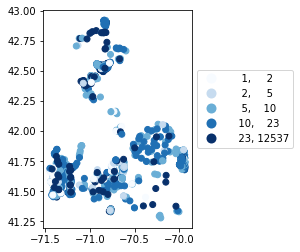

In [11]:
# Map number of usable results at each station
gdf_count = visualize.map_counts(df_harmonized, stations_clipped)
gdf_count.plot(column='cnt', cmap='Blues', legend=True, scheme='quantiles', legend_kwds={"fmt": "{:.0f}", 'bbox_to_anchor':(1, 0.75)})

<AxesSubplot:>

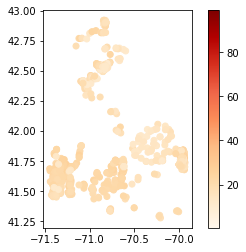

In [12]:
# Map average temperature results at each station
gdf_temperature = visualize.map_measure(df_harmonized, stations_clipped, 'Temperature')
gdf_temperature.plot(column='mean', cmap='OrRd', legend=True)

#### Clean additional columns of data

In [13]:
df_cleaned = clean.datetime(df_harmonized)  # datetime
df_cleaned = clean.harmonize_depth(df_cleaned)  # Sample depth

D:\Python\env\arcgispro-py3-spy-harmonize-wq\lib\site-packages\pandas\core\dtypes\cast.py:1990: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values


#### Reduce data to the columns that are most commonly needed

There are many columns in the dataframe that are characteristic specific, that is they have different values for the same sample depending on the characteristic. To ensure one result for each sample after the transformation of the data these columns must either be split, generating a new column for each characteristic with values, or moved out from the table if not being used.

In [14]:
# Split single QA column into multiple by characteristic (rename the result to preserve these QA_flags)
df_expanded = wrangle.split_col(df_cleaned)
df_expanded

,OrganizationIdentifier,OrganizationFormalName,ActivityIdentifier,MonitoringLocationIdentifier,ResultIdentifier,DataLoggerLine,ResultDetectionConditionText,MethodSpecificationName,CharacteristicName,ResultSampleFractionText,...,QA_TDP_Phosphorus,QA_Other_Phosphorus,QA_Unfiltered_Phosphorus,QA_Bed_Sediment_Phosphorus,QA_Temperature,QA_pH,QA_Salinity,QA_Carbon,QA_Fecal_Coliform,QA_Chlorophyll
0,CRWA,Charles River Watershed Association (Massachus...,CRWA-CYN20130809ROBTemp01,CRWA-ROB,STORET-591631481,1.308091e+11,NaN,NaN,"Temperature, water",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,11NPSWRD_WQX,National Park Service Water Resources Division,11NPSWRD_WQX-CACO_HX23_1_7/15/2013_NFW_0.957,11NPSWRD_WQX-CACO_HX23_1,STORET-920925644,NaN,NaN,NaN,"Temperature, water",Total,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,MASSDEP,Massachusetts Department of Environmental Prot...,MASSDEP-LB-5142,MASSDEP-W2173,STORET-762955917,NaN,NaN,NaN,Chlorophyll a,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,IRWA,Ipswich River Watershed Association (Volunteer),IRWA-HB:20130630120000:FM,IRWA-HB,STORET-853064665,NaN,NaN,NaN,Dissolved oxygen (DO),NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,CRWA,Charles River Watershed Association (Massachus...,CRWA-VMM20131217609SEC02,CRWA-609S,STORET-872379847,NaN,NaN,None,Escherichia coli,Total,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295766,USGS-MA,USGS Massachusetts Water Science Center,nwisma.01.02201090,USGS-01096548,NWIS-123268772,NaN,NaN,NaN,"Temperature, water",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
295767,USGS-MA,USGS Massachusetts Water Science Center,nwisma.01.02201090,USGS-01096548,NWIS-123268782,NaN,NaN,NaN,pH,Total,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
295768,USGS-MA,USGS Massachusetts Water Science Center,nwisma.01.02201090,USGS-01096548,NWIS-123268789,NaN,NaN,NaN,Escherichia coli,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
295769,USGS-MA,USGS Massachusetts Water Science Center,nwisma.01.02201090,USGS-01096548,NWIS-123268791,NaN,NaN,NaN,Turbidity,Total,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
# Split table into main with columns of interest and characteristic specific columns/metadata
#116 columns into 47 and 69
main_df, chars_df = wrangle.split_table(df_expanded)

In [16]:
# Drop empty columns (QA columns without flags)
main_df_small = main_df.dropna(axis=1, how='all')

#### Transform data from long to wide format

In [17]:
transformed_df = wrangle.collapse_results(main_df_small)

Results are collapsed by retaining the first result that isn't NAN. There can be several reasons for multiple results for the same parameter/characteristic sampled at the same station, time and by the same organization. The collapse_results function assumes the user has already reviewed the quality of all results and narrowed down instances of multiple results to only the desired/best/highest quality result before running this function.

### Detailed step-by-step workflow

#### Download location data using dataretrieval

In [18]:
# Build query with characteristicNames and the AOI extent
query = {'characteristicName': ['Phosphorus',
                                'Temperature, water',
                                'Depth, Secchi disk depth',
                                'Dissolved oxygen (DO)',
                                'Salinity',
                                'pH',
                                'Nitrogen',
                                'Conductivity',
                                'Organic carbon',
                                'Chlorophyll a',
                                'Turbidity',
                                'Sediment',
                                'Fecal Coliform',
                                'Escherichia coli']}
query['bBox'] = bBox

In [19]:
# Query stations (can be slow)
stations, site_md = wqp.what_sites(**query)

In [20]:
# Rows and columns for results
stations.shape

(7133, 37)

In [21]:
# First 5 rows
stations.head()

,OrganizationIdentifier,OrganizationFormalName,MonitoringLocationIdentifier,MonitoringLocationName,MonitoringLocationTypeName,MonitoringLocationDescriptionText,HUCEightDigitCode,DrainageAreaMeasure/MeasureValue,DrainageAreaMeasure/MeasureUnitCode,ContributingDrainageAreaMeasure/MeasureValue,...,AquiferName,LocalAqfrName,FormationTypeText,AquiferTypeName,ConstructionDateText,WellDepthMeasure/MeasureValue,WellDepthMeasure/MeasureUnitCode,WellHoleDepthMeasure/MeasureValue,WellHoleDepthMeasure/MeasureUnitCode,ProviderName
0,USGS-MA,USGS Massachusetts Water Science Center,USGS-010965305,MERRIMACK R NR TYNGSBOROUGH BRIDGE TYNGSBOROUG...,Stream,NaN,1070006.0,4070.00,sq mi,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
1,USGS-MA,USGS Massachusetts Water Science Center,USGS-01096544,"STONY BROOK AT SCHOOL STREET AT CHELMSFORD, MA",Stream,NaN,1070006.0,41.57,sq mi,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
2,USGS-MA,USGS Massachusetts Water Science Center,USGS-01096546,"STONY BROOK AT CHELMSFORD, MA",Stream,NaN,1070006.0,43.60,sq mi,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
3,USGS-MA,USGS Massachusetts Water Science Center,USGS-01096548,"STONY BROOK AT N CHELMSFORD, MA",Stream,NaN,1070006.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
4,USGS-MA,USGS Massachusetts Water Science Center,USGS-01096550,"MERRIMACK RIVER ABOVE LOWELL, MA",Stream,NaN,1070006.0,3900.00,sq mi,3900.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS


In [22]:
# Columns used for an example row
stations.iloc[0][['HorizontalCoordinateReferenceSystemDatumName', 'LatitudeMeasure', 'LongitudeMeasure']]

HorizontalCoordinateReferenceSystemDatumName        NAD83
LatitudeMeasure                                 42.677389
LongitudeMeasure                               -71.421056
Name: 0, dtype: object

In [23]:
# Harmonize location datums to 4326 (Note we keep intermediate columns using intermediate_columns=True)
stations_gdf = location.harmonize_locations(stations, outEPSG=4326, intermediate_columns=True)

In [24]:
# Every function has a dostring to help understand input/output and what it does
location.harmonize_locations?

In [25]:
# Rows and columns for results after running the function (5 new columns, only 2 new if intermediate_columns=False)
stations_gdf.shape

(7133, 42)

In [26]:
# Example results for the new columns
stations_gdf.iloc[0][['geom_orig', 'EPSG', 'QA_flag', 'geom', 'geometry']]

geom_orig         (-71.4210556, 42.67738889)
EPSG                                  4269.0
QA_flag                                  NaN
geom         POINT (-71.4210556 42.67738889)
geometry     POINT (-71.4210556 42.67738889)
Name: 0, dtype: object

In [27]:
# geom and geometry look the same but geometry is a special datatype
stations_gdf['geometry'].dtype

In [28]:
# Look at QA_flag for one w/ bad datum
stations_gdf.loc[stations_gdf['QA_flag'].notna()].iloc[0]['QA_flag']

'HorizontalCoordinateReferenceSystemDatumName: Bad datum UNKWN, EPSG:4326 assumed'

In [29]:
# Clip to area of interest
stations_clipped = wrangle.clip_stations(stations_gdf, aoi_gdf)

<AxesSubplot:>

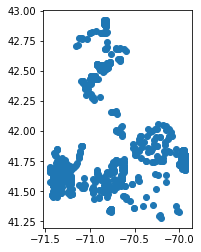

In [30]:
# Map it
stations_clipped.plot()

In [31]:
# How many stations now?
len(stations_clipped)

1151

In [32]:
# To save the results to a shapefile
#import os
#path = ''  #specify the path (folder/directory) to save it to
#stations_clipped.to_file(os.path.join(, path, )'CapeCod_stations.shp'))

#### Retrieve Characteristic Data

In [33]:
# Now query for results
query['dataProfile'] = 'narrowResult'
res_narrow, md_narrow = wqp.get_results(**query)

D:\Python\env\arcgispro-py3-spy-harmonize-wq\lib\site-packages\ipykernel_launcher.py:3: DtypeWarning: Columns (10,13,15,17,19,20,21,22,23,28,31,32,33,34,36,38,60,63,64,65,69,70,71,72) have mixed types.Specify dtype option on import or set low_memory=False.
  This is separate from the ipykernel package so we can avoid doing imports until


In [34]:
df = res_narrow
df

,OrganizationIdentifier,OrganizationFormalName,ActivityIdentifier,ActivityStartDate,ActivityStartTime/Time,ActivityStartTime/TimeZoneCode,MonitoringLocationIdentifier,ResultIdentifier,DataLoggerLine,ResultDetectionConditionText,...,AnalysisEndTime/TimeZoneCode,ResultLaboratoryCommentCode,ResultLaboratoryCommentText,ResultDetectionQuantitationLimitUrl,LaboratoryAccreditationIndicator,LaboratoryAccreditationAuthorityName,TaxonomistAccreditationIndicator,TaxonomistAccreditationAuthorityName,LabSamplePreparationUrl,ProviderName
0,CRWA,Charles River Watershed Association (Massachus...,CRWA-CYN20130809ROBTemp01,2013-08-09,11:14:33,EST,CRWA-ROB,STORET-591631481,1.308091e+11,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STORET
1,11NPSWRD_WQX,National Park Service Water Resources Division,11NPSWRD_WQX-CACO_HX23_1_7/15/2013_NFW_0.957,2013-07-15,12:17:00,EDT,11NPSWRD_WQX-CACO_HX23_1,STORET-920925644,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STORET
2,MASSDEP,Massachusetts Department of Environmental Prot...,MASSDEP-LB-5142,2013-07-30,14:20:00,EDT,MASSDEP-W2173,STORET-762955917,NaN,NaN,...,NaN,NaN,NaN,https://www.waterqualitydata.us/data/providers...,NaN,NaN,NaN,NaN,NaN,STORET
3,IRWA,Ipswich River Watershed Association (Volunteer),IRWA-HB:20130630120000:FM,2013-06-30,12:00:00,EDT,IRWA-HB,STORET-853064665,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STORET
4,CRWA,Charles River Watershed Association (Massachus...,CRWA-VMM20131217609SEC02,2013-12-17,07:40:00,EST,CRWA-609S,STORET-872379847,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STORET
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295766,USGS-MA,USGS Massachusetts Water Science Center,nwisma.01.02201090,2022-05-05,12:15:00,EDT,USGS-01096548,NWIS-123268772,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
295767,USGS-MA,USGS Massachusetts Water Science Center,nwisma.01.02201090,2022-05-05,12:15:00,EDT,USGS-01096548,NWIS-123268782,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
295768,USGS-MA,USGS Massachusetts Water Science Center,nwisma.01.02201090,2022-05-05,12:15:00,EDT,USGS-01096548,NWIS-123268789,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
295769,USGS-MA,USGS Massachusetts Water Science Center,nwisma.01.02201090,2022-05-05,12:15:00,EDT,USGS-01096548,NWIS-123268791,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS


<AxesSubplot:>

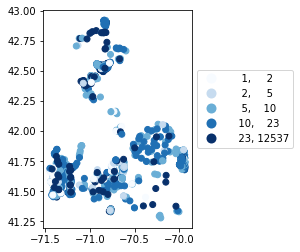

In [35]:
# Map number of usable results at each station
gdf_count = visualize.map_counts(df, stations_clipped)
gdf_count.plot(column='cnt', cmap='Blues', legend=True, scheme='quantiles', legend_kwds={"fmt": "{:.0f}", 'bbox_to_anchor':(1, 0.75)})

#### Harmonize Characteristic Results

Two options for functions to harmonize characteristics: harmonize_all() or harmonize_generic().
harmonize_all runs functions on all characteristics and lets you specify how to handle errors
harmonize_generic runs functions only on the characteristic specified with char_val and lets you also
choose output units, to keep intermediate columns and to do a quick report summarizing changes.

In [36]:
# See Documentation
#harmonize_WQP.harmonize_all?
#harmonize_WQP.harmonize_generic?

##### secchi disk depth

D:\code\harmonize-wq\harmonize_wq\harmonize.py:154: UserWarning: WARNING: 'None' UNDEFINED UNIT for Secchi
  warn("WARNING: " + problem)


-Usable results-
count    4665.000000
mean      -13.001908
std       413.943865
min     -9999.000000
25%         1.700000
50%         3.500000
75%         6.100000
max        19.380200
dtype: float64
Unusable results: 264
Usable results with inferred units: 0
Results outside threshold (0.0 to 2470.66128269025): 16


D:\Python\env\arcgispro-py3-spy-harmonize-wq\lib\site-packages\pandas\core\dtypes\cast.py:1990: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values


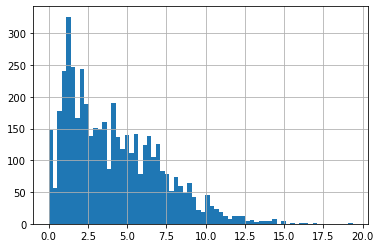

In [37]:
# Each harmonize function has optional params, e.g., char_val is the characticName column value to use so we can send the entire df.
# Optional params: units='m', char_val='Depth, Secchi disk depth', out_col='Secchi', report=False)

# We start by demonstrating on secchi disk depth (units default to m, keep intermediate fields, see report)
df = harmonize.harmonize_generic(df, 'Depth, Secchi disk depth', intermediate_columns=True, report=True)

The threshold is based on standard deviations and is currently only used in the histogram.

In [38]:
# Look at a table of just Secchi results and focus on subset of columns
cols = ['MonitoringLocationIdentifier', 'ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Units']
sechi_results = df.loc[df['CharacteristicName']=='Depth, Secchi disk depth', cols + ['Secchi']]
sechi_results

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Units,Secchi
17,11113300-GRTKINSD,3.25,m,NaN,m,3.25 meter
140,11113300-BEADERD,4.25,m,NaN,m,4.25 meter
312,11113300-ANGSDND,3.5,m,NaN,m,3.5 meter
337,NALMS-F612242,2,m,NaN,m,2.0 meter
579,11113300-GRTKINSD,2.25,m,NaN,m,2.25 meter
...,...,...,...,...,...,...
294374,11NPSWRD_WQX-CACO_DUCK_W,10.0,m,NaN,m,10.0 meter
294375,11NPSWRD_WQX-CACO_DUCK_W,17.0,m,NaN,m,17.0 meter
294376,11NPSWRD_WQX-CACO_DUCK_W,16.0,m,NaN,m,16.0 meter
294377,11NPSWRD_WQX-CACO_GREAT_W,7.8,m,NaN,m,7.8 meter


In [39]:
# Look at unusable(NAN) results
sechi_results.loc[df['Secchi'].isna()]

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Units,Secchi
16131,NARS_WQX-NLA12_MA-102,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,m,NaN
28796,EPA_OCMA_R1-SS-2,dark,m,"ResultMeasureValue: ""dark"" result cannot be used",m,NaN
31602,EPA_OCMA_R1-SS-3,dark,m,"ResultMeasureValue: ""dark"" result cannot be used",m,NaN
33548,EPA_OCMA_R1-R1-23,dark,m,"ResultMeasureValue: ""dark"" result cannot be used",m,NaN
35722,EPA_OCMA_R1-R1-25,dark,m,"ResultMeasureValue: ""dark"" result cannot be used",m,NaN
...,...,...,...,...,...,...
221803,11NPSWRD_WQX-CACO_GREAT_W,NaN,m,ResultMeasureValue: missing (NaN) result,m,NaN
221853,11NPSWRD_WQX-CACO_GREAT_W,NaN,m,ResultMeasureValue: missing (NaN) result,m,NaN
222090,11NPSWRD_WQX-CACO_GREAT_W,NaN,m,ResultMeasureValue: missing (NaN) result,m,NaN
222599,11NPSWRD_WQX-CACO_GREAT_W,NaN,m,ResultMeasureValue: missing (NaN) result,m,NaN


In [40]:
# look at the QA flag for first row from above
list(sechi_results.loc[df['Secchi'].isna()]['QA_flag'])[0]

'ResultMeasureValue: missing (NaN) result; ResultMeasure/MeasureUnitCode: MISSING UNITS, m assumed'

In [41]:
# All cases where there was a QA flag
sechi_results.loc[df['QA_flag'].notna()]

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Units,Secchi
16131,NARS_WQX-NLA12_MA-102,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,m,NaN
28761,NARS_WQX-NCCA10-1070,-9,None,ResultMeasure/MeasureUnitCode: 'None' UNDEFINE...,m,-9.0 meter
28796,EPA_OCMA_R1-SS-2,dark,m,"ResultMeasureValue: ""dark"" result cannot be used",m,NaN
28936,NARS_WQX-NCCA10-1029,-9,None,ResultMeasure/MeasureUnitCode: 'None' UNDEFINE...,m,-9.0 meter
30115,NARS_WQX-NCCA10-1001,-9,None,ResultMeasure/MeasureUnitCode: 'None' UNDEFINE...,m,-9.0 meter
...,...,...,...,...,...,...
221803,11NPSWRD_WQX-CACO_GREAT_W,NaN,m,ResultMeasureValue: missing (NaN) result,m,NaN
221853,11NPSWRD_WQX-CACO_GREAT_W,NaN,m,ResultMeasureValue: missing (NaN) result,m,NaN
222090,11NPSWRD_WQX-CACO_GREAT_W,NaN,m,ResultMeasureValue: missing (NaN) result,m,NaN
222599,11NPSWRD_WQX-CACO_GREAT_W,NaN,m,ResultMeasureValue: missing (NaN) result,m,NaN


All these were missing both a value and unit so nothing could be done

In [42]:
# Aggregate secchi data by station
visualize.station_summary(sechi_results, 'Secchi')

,MonitoringLocationIdentifier,cnt,mean
0,11113300-ANGSDND,42,3.796369
1,11113300-BEADERD,42,3.644048
2,11113300-CANWIND,22,6.144000
3,11113300-CAPSALD,24,2.456262
4,11113300-COBWINND,21,3.768810
...,...,...,...
617,NARS_WQX-NLA_MA-10032,1,3.150000
618,NARS_WQX-NLA_RI-10051,1,1.965000
619,NARS_WQX-NLA_RI-10062,1,2.540000
620,USGS-01113895,1,19.380200


D:\Python\env\arcgispro-py3-spy-harmonize-wq\lib\site-packages\mapclassify\classifiers.py:239: UserWarning: Warning: Not enough unique values in array to form k classes
  "Warning: Not enough unique values in array to form k classes", UserWarning
D:\Python\env\arcgispro-py3-spy-harmonize-wq\lib\site-packages\mapclassify\classifiers.py:241: UserWarning: Warning: setting k to 4
  Warn("Warning: setting k to %d" % k_q, UserWarning)


<AxesSubplot:>

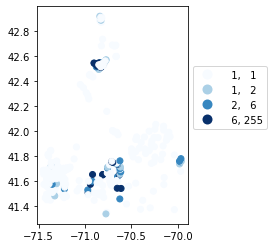

In [43]:
# Map number of usable results at each station
gdf_count = visualize.map_counts(sechi_results, stations_clipped)
gdf_count.plot(column='cnt', cmap='Blues', legend=True, scheme='quantiles', legend_kwds={"fmt": "{:.0f}", 'bbox_to_anchor':(1, 0.75)})

<AxesSubplot:>

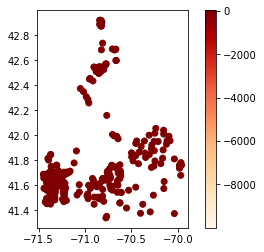

In [44]:
# Map average results at each station
gdf_avg = visualize.map_measure(sechi_results, stations_clipped, 'Secchi')
gdf_avg.plot(column='mean', cmap='OrRd', legend=True)

##### Temperature

The default error='raise', makes it so that there is an error when there is a dimensionality error (i.e. when units can't be converted). Here we would get the error: DimensionalityError: Cannot convert from 'count' (dimensionless) to 'degree_Celsius' ([temperature])

D:\Python\env\arcgispro-py3-spy-harmonize-wq\lib\site-packages\pandas\core\dtypes\cast.py:1990: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values


-Usable results-
count    88227.000000
mean        15.593035
std          7.665931
min         -6.000000
25%         10.400000
50%         15.900000
75%         21.500000
max        910.000000
dtype: float64
Unusable results: 210
Usable results with inferred units: 217
Results outside threshold (0.0 to 61.58861785274824): 113


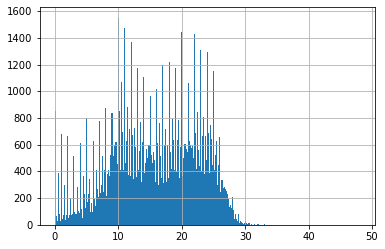

In [45]:
#'Temperature, water'
# errors=‘ignore’, invalid dimension conversions will return the NaN.
df = harmonize.harmonize_generic(df, 'Temperature, water', intermediate_columns=True, report=True, errors='ignore')

In [46]:
# Look at what was changed
cols = ['MonitoringLocationIdentifier', 'ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Temperature', 'Units']
temperature_results = df.loc[df['CharacteristicName']=='Temperature, water', cols]
temperature_results

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Temperature,Units
0,CRWA-ROB,23.01,deg C,NaN,23.01 degree_Celsius,degC
1,11NPSWRD_WQX-CACO_HX23_1,26.1,deg C,NaN,26.1 degree_Celsius,degC
8,CRWA-635S,5.5,deg C,NaN,5.5 degree_Celsius,degC
15,CRWA-4LONG,28.2,deg C,NaN,28.2 degree_Celsius,degC
24,11113300-BCHHSPHAMLF,15,deg C,NaN,15.0 degree_Celsius,degC
...,...,...,...,...,...,...
295754,USGS-414020070234801,11.1,deg C,NaN,11.1 degree_Celsius,degC
295756,USGS-01096548,8.3,deg C,NaN,8.3 degree_Celsius,degC
295762,USGS-01116617,21.8,deg C,NaN,21.8 degree_Celsius,degC
295764,USGS-414016070235104,14.2,deg C,NaN,14.2 degree_Celsius,degC


In the above we can see examples where the results were in deg F and in the result field they've been converted into degree_Celsius

In [47]:
# Examine missing units
temperature_results.loc[df['ResultMeasure/MeasureUnitCode'].isna()]

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Temperature,Units
82626,AQUINNAH-MEN TXCO,0,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",0.0 degree_Celsius,degC
82627,AQUINNAH-MEN TXCO,0,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",0.0 degree_Celsius,degC
82628,AQUINNAH-MEN TXCO,0,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",0.0 degree_Celsius,degC
82629,AQUINNAH-MEN TXCO,0,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",0.0 degree_Celsius,degC
82630,AQUINNAH-MEN TXCO,0,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",0.0 degree_Celsius,degC
...,...,...,...,...,...,...
83966,AQUINNAH-MEN PND Q,0,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",0.0 degree_Celsius,degC
83967,AQUINNAH-MEN PND Q,0,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",0.0 degree_Celsius,degC
83969,AQUINNAH-MEN PND Q,0,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",0.0 degree_Celsius,degC
103058,AQUINNAH-MEN PND HC,0,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",0.0 degree_Celsius,degC


We can see where the units were missing, the results were assumed to be in degree_Celsius already

In [48]:
# This is also noted in the QA_flag field
list(temperature_results.loc[df['ResultMeasure/MeasureUnitCode'].isna(), 'QA_flag'])[0]

'ResultMeasure/MeasureUnitCode: MISSING UNITS, degC assumed'

In [49]:
# Look for any without usable results
temperature_results.loc[df['Temperature'].isna()]

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Temperature,Units
276,MERRIMACK_RIVER_WATERSHED_WQX-Hayden-Schofield,8,count,NaN,NaN,count
2882,MERRIMACK_RIVER_WATERSHED_WQX-Manchester,8,count,NaN,NaN,count
3349,MERRIMACK_RIVER_WATERSHED_WQX-Nina-Scarito,8,count,NaN,NaN,count
4164,MERRIMACK_RIVER_WATERSHED_WQX-Misserville,8,count,NaN,NaN,count
4438,MERRIMACK_RIVER_WATERSHED_WQX-Ferrous,8,count,NaN,NaN,count
...,...,...,...,...,...,...
160772,11NPSWRD_WQX-SAIR_SWC_SR3,NaN,deg C,ResultMeasureValue: missing (NaN) result,NaN,degC
178011,11NPSWRD_WQX-SAIR_SWC_SR6,NaN,deg C,ResultMeasureValue: missing (NaN) result,NaN,degC
179257,11NPSWRD_WQX-SAIR_SWC_SR7,NaN,deg C,ResultMeasureValue: missing (NaN) result,NaN,degC
183735,11NPSWRD_WQX-SAIR_SWC_SRT9,NaN,deg C,ResultMeasureValue: missing (NaN) result,NaN,degC


In [50]:
# Aggregate temperature data by station
visualize.station_summary(temperature_results, 'Temperature')

,MonitoringLocationIdentifier,cnt,mean
0,11113300-00-SPB,21,10.909524
1,11113300-00F-KLY,3,20.233333
2,11113300-01-BAK,10,20.600000
3,11113300-01-BVR,1,21.000000
4,11113300-01-CTP,39,24.438462
...,...,...,...
4509,USGS-425447071234501,1,9.400000
4510,USGS-425450070513101,1,8.800000
4511,USGS-425456071260901,1,8.000000
4512,USGS-425517071041001,2,15.750000


<AxesSubplot:>

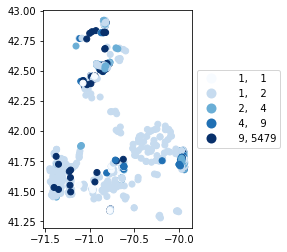

In [51]:
# Map number of usable results at each station
gdf_count = visualize.map_counts(temperature_results, stations_clipped)
gdf_count.plot(column='cnt', cmap='Blues', legend=True, scheme='quantiles', legend_kwds={"fmt": "{:.0f}", 'bbox_to_anchor':(1, 0.75)})

<AxesSubplot:>

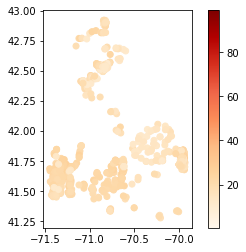

In [52]:
# Map average results at each station
gdf_avg = visualize.map_measure(temperature_results, stations_clipped, 'Temperature')
gdf_avg.plot(column='mean', cmap='OrRd', legend=True)

##### Dissolved Oxygen (DO)

In [53]:
# look at Dissolved oxygen (DO), but this time without intermediate fields
df = harmonize.harmonize_generic(df, 'Dissolved oxygen (DO)')

D:\Python\env\arcgispro-py3-spy-harmonize-wq\lib\site-packages\pandas\core\dtypes\cast.py:1990: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values


Note: Imediately when we run a harmonization function without the intermediate fields they're deleted.

In [54]:
# Look at what was changed
cols = ['MonitoringLocationIdentifier', 'ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'DO']
do_res = df.loc[df['CharacteristicName']=='Dissolved oxygen (DO)', cols]
do_res

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,DO
3,IRWA-HB,4.6,mg/l,NaN,4.6 milligram / liter
6,MYRWA-MEB001,9.4,mg/l,NaN,9.4 milligram / liter
7,NARS_WQX-MARO-1020,10.3,mg/l,NaN,10.3 milligram / liter
9,MASSDEP-W2412,8.7,mg/l,NaN,8.7 milligram / liter
11,MERRIMACK_RIVER_WATERSHED_WQX-Central Catholic,10.91,mg/l,NaN,10.91 milligram / liter
...,...,...,...,...,...
290329,11NPSWRD_WQX-CACO_GREAT_W,6.1,mg/l,NaN,6.1 milligram / liter
290332,11NPSWRD_WQX-SAMA_EPG_SHC,14.2,mg/l,NaN,14.2 milligram / liter
290333,11NPSWRD_WQX-SAMA_EPG_SHD,8.5,mg/l,NaN,8.5 milligram / liter
290339,11NPSWRD_WQX-SAMA_EPG_SHC,9.1,mg/l,NaN,9.1 milligram / liter


In [55]:
do_res.loc[do_res['ResultMeasure/MeasureUnitCode']!='mg/l']

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,DO
31,MYRWA-UPL001,90.4507616092312,%,NaN,7.473342598767408 milligram / liter
95,MYRWA-WIB001,84.5873227769873,%,NaN,6.988885791321319 milligram / liter
134,MYRWA-UPL001,90.4507286557983,%,NaN,7.473339876045239 milligram / liter
175,MYRWA-ABR028,67.5488322678976,%,NaN,5.5811090664509475 milligram / liter
196,MYRWA-ABR028,79.3792214567991,%,NaN,6.558575147581124 milligram / liter
...,...,...,...,...,...
223828,11NPSWRD_WQX-SAMA_SESD_CIM,5.21,ml/l,NaN,0.04304675189778 milligram / liter
224153,11NPSWRD_WQX-SAMA_SESD_GHI,5.61,ml/l,NaN,0.04635168486498 milligram / liter
224181,11NPSWRD_WQX-SAMA_SESD_CI,4.10,ml/l,NaN,0.03387556291379999 milligram / liter
224377,11NPSWRD_WQX-SAMA_SESD_BI,5.90,ml/l,NaN,0.04874776126620001 milligram / liter


Though there were no results in %, the conversion from percent saturation (%) to mg/l is special. This equation is being improved by integrating tempertaure and pressure instead of assuming STP (see DO_saturation())

In [56]:
# Aggregate data by station
visualize.station_summary(do_res, 'DO')

,MonitoringLocationIdentifier,cnt,mean
0,11113300-00F-KLY,3,4.040000
1,11113300-01-BAK,10,5.697000
2,11113300-01-BVR,1,6.700000
3,11113300-01-CTP,37,6.945135
4,11113300-01-GOL,1,4.400000
...,...,...,...
1918,OARS-SUD-096,48,5.300833
1919,OARS-SUD-098,14,6.037143
1920,OARS-SUD-144,86,9.317209
1921,OARS-SUD-236,3,7.813333


<AxesSubplot:>

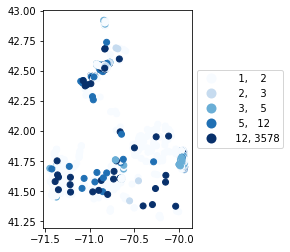

In [57]:
# Map number of usable results at each station
gdf_count = visualize.map_counts(do_res, stations_clipped)
gdf_count.plot(column='cnt', cmap='Blues', legend=True, scheme='quantiles', legend_kwds={"fmt": "{:.0f}", 'bbox_to_anchor':(1, 0.75)})

<AxesSubplot:>

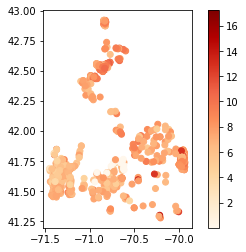

In [58]:
# Map average results at each station
gdf_avg = visualize.map_measure(do_res, stations_clipped, 'DO')
gdf_avg.plot(column='mean', cmap='OrRd', legend=True)

##### pH

D:\Python\env\arcgispro-py3-spy-harmonize-wq\lib\site-packages\pandas\core\dtypes\cast.py:1990: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values


-Usable results-
count    60604.000000
mean         6.337820
std          3.210433
min         -3.124705
25%          5.340000
50%          6.400000
75%          7.180000
max        715.000000
dtype: float64
Unusable results: 13
Usable results with inferred units: 215
Results outside threshold (0.0 to 25.600420455656923): 12


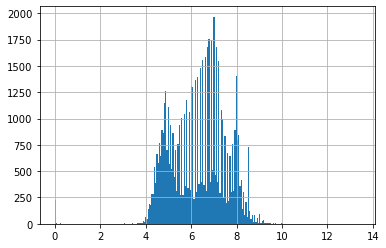

In [59]:
# pH, this time looking at a report
df = harmonize.harmonize_generic(df, 'pH', report=True)

Note the warnings that occur when a unit is not recognized by the package. These occur even when report=False. Future versions could include these as defined units for pH, but here it wouldn't alter results.

In [60]:
df.loc[df['CharacteristicName']=='pH', ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'pH']]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,pH
26,7.78,None,NaN,7.78 dimensionless
50,7.9,None,NaN,7.9 dimensionless
57,7.69,None,NaN,7.69 dimensionless
58,6.16,None,NaN,6.16 dimensionless
61,7.4,None,NaN,7.4 dimensionless
...,...,...,...,...
295755,6.2,std units,NaN,6.2 dimensionless
295757,7.4,std units,NaN,7.4 dimensionless
295763,7.0,std units,NaN,7.0 dimensionless
295765,5.4,std units,NaN,5.4 dimensionless


'None' is uninterpretable and replaced with NaN, which then gets replaced with 'dimensionless' since pH is unitless

##### Salinity

D:\code\harmonize-wq\harmonize_wq\basis.py:95: UserWarning: Mismatched ResultTemperatureBasisText: updated from 25 deg C to @25C (units)
  warn('Mismatched {}'.format(flag))
D:\Python\env\arcgispro-py3-spy-harmonize-wq\lib\site-packages\pandas\core\dtypes\cast.py:1990: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values


-Usable results-
count    15159.000000
mean        24.939012
std         34.944346
min          0.000000
25%         24.000000
50%         30.600000
75%         31.600000
max       4003.482834
dtype: float64
Unusable results: 217
Usable results with inferred units: 1
Results outside threshold (0.0 to 234.60508901267156): 2


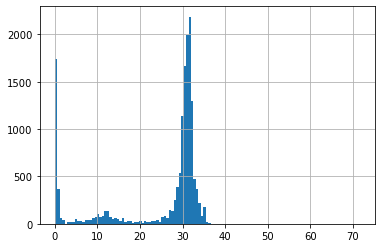

In [61]:
# Salinity
# Note: this has some weird units ('deg C') that may cause issue unless ignored
df = harmonize.harmonize_generic(df, 'Salinity', report=True, errors='ignore')

In [62]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Salinity']
df.loc[df['CharacteristicName']=='Salinity', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Salinity
14,32.43,ppt,NaN,32.43 Practical_Salinity_Units
21,33.3,ppth,NaN,33.3 Practical_Salinity_Units
27,31.81,ppt,NaN,31.81 Practical_Salinity_Units
44,30.77,ppt,NaN,30.77 Practical_Salinity_Units
48,32.7,ppth,NaN,32.7 Practical_Salinity_Units
...,...,...,...,...
290334,32.0,ppth,NaN,32.0 Practical_Salinity_Units
290335,30.0,ppth,NaN,30.0 Practical_Salinity_Units
290336,7.5,ppth,NaN,7.5 Practical_Salinity_Units
290344,33.5,ppth,NaN,33.5 Practical_Salinity_Units


##### Nitrogen

D:\code\harmonize-wq\harmonize_wq\harmonize.py:154: UserWarning: WARNING: 'cm3/g' UNDEFINED UNIT for Nitrogen
  warn("WARNING: " + problem)
D:\code\harmonize-wq\harmonize_wq\harmonize.py:154: UserWarning: WARNING: 'percent' UNDEFINED UNIT for Nitrogen
  warn("WARNING: " + problem)
D:\code\harmonize-wq\harmonize_wq\harmonize.py:154: UserWarning: WARNING: 'ppm' UNDEFINED UNIT for Nitrogen
  warn("WARNING: " + problem)
D:\Python\env\arcgispro-py3-spy-harmonize-wq\lib\site-packages\numpy\core\_asarray.py:102: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return array(a, dtype, copy=False, order=order)
D:\Python\env\arcgispro-py3-spy-harmonize-wq\lib\site-packages\pandas\core\dtypes\cast.py:1990: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values


-Usable results-
count    2111.000000
mean        1.507030
std         4.315574
min         0.000800
25%         0.087000
50%         0.263668
75%         1.030000
max        30.080000
dtype: float64
Unusable results: 137
Usable results with inferred units: 0
Results outside threshold (0.0 to 27.400476241602878): 2


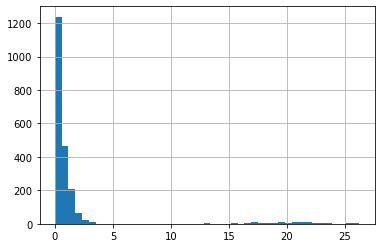

In [63]:
# Note Nitrogen value as '%' is in there for Cape, but weird
# Nitrogen had a problem with one of the units that is unexepected
df = harmonize.harmonize_generic(df, 'Nitrogen', report=True)

In [64]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Nitrogen']
df.loc[df['CharacteristicName']=='Nitrogen', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Nitrogen
646,0.926976,mg/l,NaN,0.926976 milligram / liter
741,1.571196,mg/l,NaN,1.571196 milligram / liter
747,0.816144,mg/l,NaN,0.816144 milligram / liter
1004,0.848832,mg/l,NaN,0.848832 milligram / liter
1051,0.770448,mg/l,NaN,0.770448 milligram / liter
...,...,...,...,...
295683,0.034,mg/l,NaN,0.034 milligram / liter
295699,0.075,mg/l,NaN,0.075 milligram / liter
295733,0.059,mg/l,NaN,0.059 milligram / liter
295742,0.144,mg/l,NaN,0.144 milligram / liter


##### Conductivity

D:\Python\env\arcgispro-py3-spy-harmonize-wq\lib\site-packages\pandas\core\dtypes\cast.py:1990: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values


-Usable results-
count     1634.000000
mean      1177.938719
std       3742.953777
min          0.000000
25%        326.000000
50%        451.000000
75%        595.000000
max      39960.000000
dtype: float64
Unusable results: 19
Usable results with inferred units: 0
Results outside threshold (0.0 to 23635.661383588707): 19


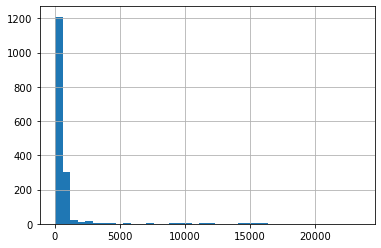

In [65]:
df = harmonize.harmonize_generic(df, 'Conductivity', report=True, errors='ignore')

In [66]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Conductivity']
df.loc[df['CharacteristicName']=='Conductivity', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Conductivity
18,349,uS/cm,NaN,349.0 microsiemens / centimeter
22,8,count,NaN,NaN
33,443,uS/cm,NaN,443.0 microsiemens / centimeter
41,67.11703531,uS/cm,NaN,67.11703531 microsiemens / centimeter
68,590,uS/cm,NaN,590.0 microsiemens / centimeter
...,...,...,...,...
168206,621,uS/cm,NaN,621.0 microsiemens / centimeter
168514,426,uS/cm,NaN,426.0 microsiemens / centimeter
168562,4,uS/cm,NaN,4.0 microsiemens / centimeter
168650,673,uS/cm,NaN,673.0 microsiemens / centimeter


##### Chlorophyll a

D:\code\harmonize-wq\harmonize_wq\harmonize.py:154: UserWarning: WARNING: 'ppb' UNDEFINED UNIT for Chlorophyll
  warn("WARNING: " + problem)
D:\code\harmonize-wq\harmonize_wq\harmonize.py:154: UserWarning: WARNING: 'ug/cm2' UNDEFINED UNIT for Chlorophyll
  warn("WARNING: " + problem)
D:\code\harmonize-wq\harmonize_wq\harmonize.py:154: UserWarning: WARNING: 'ug/m3' UNDEFINED UNIT for Chlorophyll
  warn("WARNING: " + problem)
D:\Python\env\arcgispro-py3-spy-harmonize-wq\lib\site-packages\pandas\core\dtypes\cast.py:1990: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values


-Usable results-
count    3784.000000
mean        0.640163
std         3.439104
min        -0.002400
25%         0.001680
50%         0.005193
75%         0.020800
max        92.900000
dtype: float64
Unusable results: 130
Usable results with inferred units: 9
Results outside threshold (0.0 to 21.274788467172712): 29


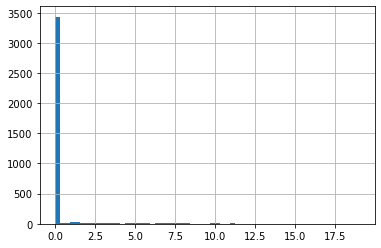

In [67]:
df = harmonize.harmonize_generic(df, 'Chlorophyll a', report=True)

In [68]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Chlorophyll']
df.loc[df['CharacteristicName']=='Chlorophyll a', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Chlorophyll
2,4.0,mg/m3,NaN,0.004000000000000001 milligram / liter
187,5.50,ug/l,NaN,0.0055 milligram / liter
344,9.48,ug/l,NaN,0.00948 milligram / liter
585,3.0,mg/m3,NaN,0.003000000000000001 milligram / liter
765,NaN,mg/m3,ResultMeasureValue: missing (NaN) result,NaN
...,...,...,...,...
295623,2.7,ug/l,NaN,0.0027 milligram / liter
295632,2.3,ug/l,NaN,0.0023 milligram / liter
295653,2.2,ug/l,NaN,0.0022 milligram / liter
295739,8.3,ug/l,NaN,0.0083 milligram / liter


##### Organic Carbon

D:\Python\env\arcgispro-py3-spy-harmonize-wq\lib\site-packages\pandas\core\dtypes\cast.py:1990: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values


-Usable results-
count      5539.000000
mean       5626.935262
std       37411.246687
min      -90000.000000
25%           1.400000
50%           4.880000
75%           8.875000
max      530000.000000
dtype: float64
Unusable results: 63
Usable results with inferred units: 0
Results outside threshold (0.0 to 230094.4153863919): 39


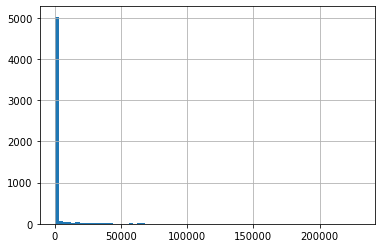

In [69]:
# Organic carbon (%)
df = harmonize.harmonize_generic(df, 'Organic carbon', report=True)

In [70]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Carbon']
df.loc[df['CharacteristicName']=='Organic carbon', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Carbon
816,7.05,mg/l,NaN,7.05 milligram / liter
928,7.57,mg/l,NaN,7.57 milligram / liter
958,3.5,mg/l,NaN,3.5 milligram / liter
2482,3.8,mg/l,NaN,3.8 milligram / liter
3200,3.7,mg/l,NaN,3.7 milligram / liter
...,...,...,...,...
295674,2.92,mg/l,NaN,2.92 milligram / liter
295682,6.47,mg/l,NaN,6.47 milligram / liter
295698,5.14,mg/l,NaN,5.14 milligram / liter
295732,3.62,mg/l,NaN,3.62 milligram / liter


##### Turbidity (NTU)

In [71]:
# Bad units include 'm' and 'count'
#df_turb = df[df['CharacteristicName']=='Turbidity']

D:\code\harmonize-wq\harmonize_wq\harmonize.py:929: UserWarning: Bad Turbidity unit: count
  warn('Bad Turbidity unit: {}'.format(unit))
D:\Python\env\arcgispro-py3-spy-harmonize-wq\lib\site-packages\pandas\core\dtypes\cast.py:1990: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values


-Usable results-
count    14417.000000
mean        31.897885
std        108.621859
min         -2.000000
25%          1.300000
50%          2.700000
75%          8.700000
max       4100.000000
dtype: float64
Unusable results: 438
Usable results with inferred units: 275
Results outside threshold (0.0 to 683.6290395954895): 99


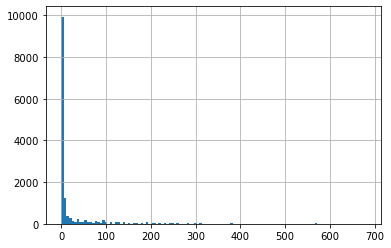

In [72]:
df = harmonize.harmonize_generic(df, 'Turbidity', report=True, errors='ignore')

In [73]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Turbidity']
df.loc[df['CharacteristicName']=='Turbidity', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Turbidity
5,1.3,NTU,NaN,1.3 Nephelometric_Turbidity_Units
10,7.9,NTU,NaN,7.9 Nephelometric_Turbidity_Units
20,1.5,NTU,NaN,1.5 Nephelometric_Turbidity_Units
47,.69,NTU,NaN,0.69 Nephelometric_Turbidity_Units
54,4.0,NTU,NaN,4.0 Nephelometric_Turbidity_Units
...,...,...,...,...
295735,2.8,NTRU,NaN,2.8 Nephelometric_Turbidity_Units
295738,2.8,NTRU,NaN,2.8 Nephelometric_Turbidity_Units
295751,2.6,NTRU,NaN,2.6 Nephelometric_Turbidity_Units
295761,1.9,NTRU,NaN,1.9 Nephelometric_Turbidity_Units


##### Sediment

In [74]:
df = harmonize.harmonize_generic(df, 'Sediment', report=False, errors='ignore')

D:\Python\env\arcgispro-py3-spy-harmonize-wq\lib\site-packages\pandas\core\dtypes\cast.py:1990: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values


In [75]:
df.loc[df['CharacteristicName']=='Sediment', ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Sediment']]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Sediment
249747,39.0,%,NaN,390.0 gram / kilogram
250138,33.0,%,NaN,330.0 gram / kilogram
262102,0.012,g,NaN,NaN
262103,0.0037,g,NaN,NaN
262104,0.0048,g,NaN,NaN
...,...,...,...,...
294770,12.5701,g,NaN,NaN
294771,4.7241,g,NaN,NaN
294870,0.0207,g,NaN,NaN
294882,0.0174,g,NaN,NaN


##### Phosphorus

Note: must be merged w/ activities (package runs query by site if not already merged)

In [76]:
df = harmonize.harmonize_generic(df, 'Phosphorus')

D:\code\harmonize-wq\harmonize_wq\harmonize.py:154: UserWarning: WARNING: 'percent' UNDEFINED UNIT for Phosphorus
  warn("WARNING: " + problem)
D:\code\harmonize-wq\harmonize_wq\harmonize.py:154: UserWarning: WARNING: 'ppm' UNDEFINED UNIT for Phosphorus
  warn("WARNING: " + problem)
D:\Python\env\arcgispro-py3-spy-harmonize-wq\lib\site-packages\numpy\core\_asarray.py:102: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return array(a, dtype, copy=False, order=order)
D:\Python\env\arcgispro-py3-spy-harmonize-wq\lib\site-packages\pandas\core\dtypes\cast.py:1990: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values
D:\code\harmonize-wq\harmonize_wq\harmonize.py:432: UserWarning: Warning: "Non-filterable_Phosphorus" column for Non-filterable, may be error
  warn('Warning: ' + prob)
D:\code\harmonize-wq\harmonize_wq\harmonize.py:432: UserWarning: Warning: "Unfiltered_Phosphorus" column for Unfilt

Note: the warnings for unexpected characteristic fractions. Fractions are each seperated out into their own result column.

In [77]:
# len(df[df['CharacteristicName']=='Phosphorus'])
list(set(df['CharacteristicName']))

['Escherichia coli',
 'Depth, Secchi disk depth',
 'Nitrogen',
 'Sediment',
 'Conductivity',
 'Turbidity',
 'Dissolved oxygen (DO)',
 'Phosphorus',
 'Temperature, water',
 'pH',
 'Salinity',
 'Organic carbon',
 'Fecal Coliform',
 'Chlorophyll a']

In [78]:
# Total dissolved phosphorus
#df.loc[df['TDP_Phosphorus'].notna(), ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'TDP_Phosphorus']]

In [79]:
# Total phosphorus
#df.loc[df['TP_Phosphorus'].notna(), ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'TP_Phosphorus']]

##### Bacteria

Some equivalence assumptions are built-in where bacteria counts that are not equivalent are treated as such because there is no standard way to convert from one to another.

###### Fecal Coliform

-Usable results-
count    6.442000e+03
mean     5.282978e+03
std      1.456090e+05
min      0.000000e+00
25%      1.725000e+01
50%      7.700000e+01
75%      3.400000e+02
max      9.300000e+06
dtype: float64
Unusable results: 1142
Usable results with inferred units: 1
Results outside threshold (0.0 to 878936.8168145075): 6


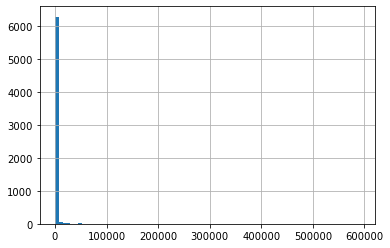

In [80]:
df = harmonize.harmonize_generic(df, 'Fecal Coliform', report=True)

In [81]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Fecal_Coliform']
df.loc[df['CharacteristicName']=='Fecal Coliform', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Fecal_Coliform
8153,710,cfu/100ml,NaN,710.0 Colony_Forming_Units / milliliter
8360,30,cfu/100ml,NaN,30.0 Colony_Forming_Units / milliliter
9212,830,cfu/100ml,NaN,830.0 Colony_Forming_Units / milliliter
9504,30,#/100ml,NaN,30.0 Colony_Forming_Units / milliliter
9753,60,#/100ml,NaN,60.0 Colony_Forming_Units / milliliter
...,...,...,...,...
289685,2400.0,cfu/100ml,NaN,2400.0 Colony_Forming_Units / milliliter
289687,230.0,cfu/100ml,NaN,230.0 Colony_Forming_Units / milliliter
289692,30.0,cfu/100ml,NaN,30.0 Colony_Forming_Units / milliliter
289696,NaN,cfu/100ml,ResultMeasureValue: missing (NaN) result,NaN


###### Excherichia Coli

D:\Python\env\arcgispro-py3-spy-harmonize-wq\lib\site-packages\pandas\core\dtypes\cast.py:1990: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values


-Usable results-
count     16668.000000
mean        546.769137
std        3505.998128
min           0.000000
25%          22.275000
50%          82.000000
75%         240.000000
max      173290.000000
dtype: float64
Unusable results: 1945
Usable results with inferred units: 0
Results outside threshold (0.0 to 21582.757902736354): 55


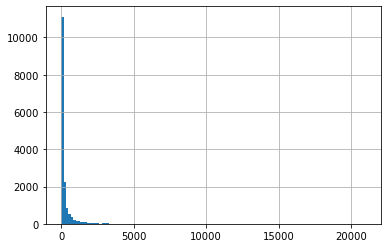

In [82]:
df = harmonize.harmonize_generic(df, 'Escherichia coli', report=True, errors='ignore')

In [83]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'E_coli']
df.loc[df['CharacteristicName']=='Escherichia coli', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,E_coli
4,96,MPN/100ml,NaN,96.0 Colony_Forming_Units / milliliter
13,24200,MPN/100ml,NaN,24200.0 Colony_Forming_Units / milliliter
16,110,MPN/100ml,NaN,110.0 Colony_Forming_Units / milliliter
19,52,MPN/100ml,NaN,52.0 Colony_Forming_Units / milliliter
23,52,MPN/100ml,NaN,52.0 Colony_Forming_Units / milliliter
...,...,...,...,...
295700,46.0,MPN/100 ml,NaN,46.0 Colony_Forming_Units / milliliter
295726,25.0,MPN/100 ml,NaN,25.0 Colony_Forming_Units / milliliter
295734,17.0,MPN/100 ml,NaN,17.0 Colony_Forming_Units / milliliter
295760,12.0,MPN/100 ml,NaN,12.0 Colony_Forming_Units / milliliter


#### Combining Salinity and Conductivity

Convert module has various functions to convert from one unit or characteristic to another. Some of these are used within a single characteristic during harmonization (e.g. DO saturation to concentration) while others are intended to model one characteristic as an indicator of another (e.g. estimate salinity from conductivity).

Note: this should only be done after both characteristic fields have been harmonized. Results before and after should be inspected, thresholds for outliers applied, and consider adding a QA_flag for modeled data.

In [84]:
# First note initial Salinity info
lst = [x.magnitude for x in list(df['Salinity'].dropna())]
q_sum = sum(lst)
print('Range: {} to {}'.format(min(lst), max(lst)))
print('Results: {} \nMean: {} PSU'.format(len(lst), q_sum/len(lst)))

Range: 0.0 to 4003.4828342857154
Results: 15159 
Mean: 24.939012230305146 PSU


In [85]:
# Create series for Conductivity values
cond_series = df['Conductivity'].dropna()
# Coerce quantity values to str (wrapper doesn't recognize quantity as it should)
cond_series = cond_series.astype(str)
# Convert values to PSU
df.loc[df['Conductivity'].notna(), 'Salinity'] = cond_series.apply(convert.conductivity_to_PSU)

In [86]:
df.loc[df['Salinity'].notna(), ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Salinity']]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Salinity
14,32.43,ppt,NaN,32.43 Practical_Salinity_Units
18,349,uS/cm,NaN,0.168 dimensionless
21,33.3,ppth,NaN,33.3 Practical_Salinity_Units
27,31.81,ppt,NaN,31.81 Practical_Salinity_Units
33,443,uS/cm,NaN,0.214 dimensionless
...,...,...,...,...
290334,32.0,ppth,NaN,32.0 Practical_Salinity_Units
290335,30.0,ppth,NaN,30.0 Practical_Salinity_Units
290336,7.5,ppth,NaN,7.5 Practical_Salinity_Units
290344,33.5,ppth,NaN,33.5 Practical_Salinity_Units


In [87]:
# Now note updated values
lst = [x.magnitude for x in list(df['Salinity'].dropna())]
q_sum = sum(lst)
print('Range: {} to {}'.format(min(lst), max(lst)))
print('Results: {} \nMean: {} PSU'.format(len(lst), q_sum/len(lst)))

Range: 0.0 to 4003.4828342857154
Results: 16793 
Mean: 22.575746406192792 PSU


In [88]:
# Better to do after transposing so it doesn't generate duplicates?
# Start with two field 'Salinity' and 'Conductivity' that have already been harmonized
# Move the data from the Conductivity field to the salinity field

#Notes:
#df[df['Conductivity'].notna(), 'Salinity'] = df[df['Conductivity'].notna()].apply(harmonize_WQP.conductivity_to_PSU)
#df['Conductivity'].dropna().equals(df[df['Conductivity'].notna()]['Conductivity'])

In [89]:
# Threshholds and reports
#e.g. PSU 0-42

#### Datetime

datetime() formats time using dataretrieval and ActivityStart

In [90]:
# First inspect the existing unformated fields
cols = ['ActivityStartDate', 'ActivityStartTime/Time', 'ActivityStartTime/TimeZoneCode']
df[cols]

,ActivityStartDate,ActivityStartTime/Time,ActivityStartTime/TimeZoneCode
0,2013-08-09,11:14:33,EST
1,2013-07-15,12:17:00,EDT
2,2013-07-30,14:20:00,EDT
3,2013-06-30,12:00:00,EDT
4,2013-12-17,07:40:00,EST
...,...,...,...
295766,2022-05-05,12:15:00,EDT
295767,2022-05-05,12:15:00,EDT
295768,2022-05-05,12:15:00,EDT
295769,2022-05-05,12:15:00,EDT


In [91]:
# Note the input columns are dropped (rename the result to preserve these columns)
df = clean.datetime(df)
df[['StartDate', 'Activity_datetime']]

,StartDate,Activity_datetime
0,2013-08-09,2013-08-09 16:14:33+00:00
1,2013-07-15,2013-07-15 16:17:00+00:00
2,2013-07-30,2013-07-30 18:20:00+00:00
3,2013-06-30,2013-06-30 16:00:00+00:00
4,2013-12-17,2013-12-17 12:40:00+00:00
...,...,...
295766,2022-05-05,2022-05-05 16:15:00+00:00
295767,2022-05-05,2022-05-05 16:15:00+00:00
295768,2022-05-05,2022-05-05 16:15:00+00:00
295769,2022-05-05,2022-05-05 16:15:00+00:00


Activity_datetime combines all three time component columns into UTC. If time is missing this is NaT so a startDate column is used to preserve date only.

#### Depth

In [92]:
# Depth of sample (default units='meter')
df = clean.harmonize_depth(df)
#df.loc[df['ResultDepthHeightMeasure/MeasureValue'].dropna(), "Depth"]
df['ResultDepthHeightMeasure/MeasureValue'].dropna()

D:\Python\env\arcgispro-py3-spy-harmonize-wq\lib\site-packages\pandas\core\dtypes\cast.py:1990: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values


8859       4.0
13473     10.0
13901      3.8
13932      2.0
13948      0.5
          ... 
113753     2.0
114077    32.0
114835    17.0
116432     2.0
116611     2.0
Name: ResultDepthHeightMeasure/MeasureValue, Length: 611, dtype: float64

Data are often lacking sample depth metadata, even this small number including depth is good

#### Characteristic to Column (long to wide format)

In [93]:
# Split single QA column into multiple by characteristic (rename the result to preserve these QA_flags)
df2 = wrangle.split_col(df)
df2

,OrganizationIdentifier,OrganizationFormalName,ActivityIdentifier,MonitoringLocationIdentifier,ResultIdentifier,DataLoggerLine,ResultDetectionConditionText,MethodSpecificationName,CharacteristicName,ResultSampleFractionText,...,QA_TDP_Phosphorus,QA_Other_Phosphorus,QA_Unfiltered_Phosphorus,QA_Bed_Sediment_Phosphorus,QA_Temperature,QA_pH,QA_Salinity,QA_Carbon,QA_Fecal_Coliform,QA_Chlorophyll
0,CRWA,Charles River Watershed Association (Massachus...,CRWA-CYN20130809ROBTemp01,CRWA-ROB,STORET-591631481,1.308091e+11,NaN,NaN,"Temperature, water",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,11NPSWRD_WQX,National Park Service Water Resources Division,11NPSWRD_WQX-CACO_HX23_1_7/15/2013_NFW_0.957,11NPSWRD_WQX-CACO_HX23_1,STORET-920925644,NaN,NaN,NaN,"Temperature, water",Total,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,MASSDEP,Massachusetts Department of Environmental Prot...,MASSDEP-LB-5142,MASSDEP-W2173,STORET-762955917,NaN,NaN,NaN,Chlorophyll a,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,IRWA,Ipswich River Watershed Association (Volunteer),IRWA-HB:20130630120000:FM,IRWA-HB,STORET-853064665,NaN,NaN,NaN,Dissolved oxygen (DO),NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,CRWA,Charles River Watershed Association (Massachus...,CRWA-VMM20131217609SEC02,CRWA-609S,STORET-872379847,NaN,NaN,None,Escherichia coli,Total,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295766,USGS-MA,USGS Massachusetts Water Science Center,nwisma.01.02201090,USGS-01096548,NWIS-123268772,NaN,NaN,NaN,"Temperature, water",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
295767,USGS-MA,USGS Massachusetts Water Science Center,nwisma.01.02201090,USGS-01096548,NWIS-123268782,NaN,NaN,NaN,pH,Total,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
295768,USGS-MA,USGS Massachusetts Water Science Center,nwisma.01.02201090,USGS-01096548,NWIS-123268789,NaN,NaN,NaN,Escherichia coli,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
295769,USGS-MA,USGS Massachusetts Water Science Center,nwisma.01.02201090,USGS-01096548,NWIS-123268791,NaN,NaN,NaN,Turbidity,Total,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [94]:
# This expands the single col (QA_flag) out to a number of new columns based on the unique characteristicNames and speciation
print('{} new columns'.format(len(df2.columns) - len(df.columns)))

17 new columns


In [95]:
# Note: there are fewer rows because NAN results are also dropped in this step
print('{} fewer rows'.format(len(df)-len(df2)))

10233 fewer rows


In [96]:
#Examine Carbon flags from earlier in notebook (note these are empty now because NAN is dropped)
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'Carbon', 'QA_Carbon']
df2.loc[df2['QA_Carbon'].notna(), cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,Carbon,QA_Carbon


Next the table is divided into the columns of interest (main_df) and characteristic specific metadata (chars_df)

In [97]:
# split table into main and characteristics tables
main_df, chars_df = wrangle.split_table(df2)

In [98]:
# Columns still in main table
main_df.columns

Index(['OrganizationIdentifier', 'OrganizationFormalName',
       'ActivityIdentifier', 'MonitoringLocationIdentifier',
       'ResultIdentifier', 'ProviderName', 'Secchi', 'Temperature', 'DO', 'pH',
       'Salinity', 'Nitrogen', 'Speciation', 'Conductivity', 'Chlorophyll',
       'Carbon', 'Turbidity', 'Sediment', 'Phosphorus', 'TP_Phosphorus',
       'TDP_Phosphorus', 'Other_Phosphorus', 'Unfiltered_Phosphorus',
       'Bed_Sediment_Phosphorus', 'Fecal_Coliform', 'E_coli', 'StartDate',
       'Activity_datetime', 'Depth', 'QA_E_coli', 'QA_Secchi', 'QA_Nitrogen',
       'QA_Sediment', 'QA_Conductivity', 'QA_Turbidity', 'QA_DO',
       'QA_TP_Phosphorus', 'QA_TDP_Phosphorus', 'QA_Other_Phosphorus',
       'QA_Unfiltered_Phosphorus', 'QA_Bed_Sediment_Phosphorus',
       'QA_Temperature', 'QA_pH', 'QA_Salinity', 'QA_Carbon',
       'QA_Fecal_Coliform', 'QA_Chlorophyll'],
      dtype='object')

In [99]:
# look at main table results (first 5)
main_df.head()

,OrganizationIdentifier,OrganizationFormalName,ActivityIdentifier,MonitoringLocationIdentifier,ResultIdentifier,ProviderName,Secchi,Temperature,DO,pH,...,QA_TDP_Phosphorus,QA_Other_Phosphorus,QA_Unfiltered_Phosphorus,QA_Bed_Sediment_Phosphorus,QA_Temperature,QA_pH,QA_Salinity,QA_Carbon,QA_Fecal_Coliform,QA_Chlorophyll
0,CRWA,Charles River Watershed Association (Massachus...,CRWA-CYN20130809ROBTemp01,CRWA-ROB,STORET-591631481,STORET,NaN,23.01 degree_Celsius,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,11NPSWRD_WQX,National Park Service Water Resources Division,11NPSWRD_WQX-CACO_HX23_1_7/15/2013_NFW_0.957,11NPSWRD_WQX-CACO_HX23_1,STORET-920925644,STORET,NaN,26.1 degree_Celsius,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,MASSDEP,Massachusetts Department of Environmental Prot...,MASSDEP-LB-5142,MASSDEP-W2173,STORET-762955917,STORET,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,IRWA,Ipswich River Watershed Association (Volunteer),IRWA-HB:20130630120000:FM,IRWA-HB,STORET-853064665,STORET,NaN,NaN,4.6 milligram / liter,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,CRWA,Charles River Watershed Association (Massachus...,CRWA-VMM20131217609SEC02,CRWA-609S,STORET-872379847,STORET,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [100]:
# Empty columns that could be dropped (Mostly QA columns)
cols = list(main_df.columns)
x = main_df.dropna(axis=1, how='all')
[col for col in cols if col not in x.columns]

['QA_E_coli',
 'QA_Sediment',
 'QA_Conductivity',
 'QA_DO',
 'QA_Unfiltered_Phosphorus',
 'QA_Carbon']

<AxesSubplot:>

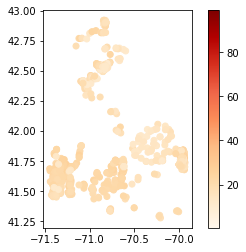

In [101]:
# Map average results at each station
gdf_avg = visualize.map_measure(main_df, stations_clipped, 'Temperature')
gdf_avg.plot(column='mean', cmap='OrRd', legend=True)